# Datasets merge

## Imports 

In [1]:
import os
import json
import numpy as np
import pandas as pd
from IPython.display import Image
from carrada_dataset.carrada_dataset.utils import CARRADA_HOME
from carrada_dataset.carrada_dataset.utils.configurable import Configurable
from carrada_dataset.carrada_dataset.utils.transform_data import DataTransformer
from carrada_dataset.carrada_dataset.utils.visualize_signal import SignalVisualizer
from carrada_dataset.carrada_dataset.utils.generate_annotations import AnnotationGenerator
from carrada_dataset.carrada_dataset.utils.transform_annotations import AnnotationTransformer

## CRUW Dataset

### define data and annotations paths

In [ ]:
data_path = '/home/hawk/Desktop/data/CRUW/TRAIN_RAD_H/'
anno_path = '/home/hawk/Desktop/data/CRUW/TRAIN_RAD_H_ANNO/'

### Load the data

In [35]:
def load_radar_data(data_path):
    radar_data = {}
    for folder in os.listdir(data_path):
        subfolder_path = os.path.join(data_path, folder, 'RADAR_RA_H')
        if os.path.isdir(subfolder_path):
            radar_files = sorted([os.path.join(subfolder_path, f) for f in os.listdir(subfolder_path) if f.endswith('.npy')])
            radar_data[folder] = [np.load(file) for file in radar_files]
    return radar_data

def load_annotations(anno_path):
    annotations = {}
    for file in os.listdir(anno_path):
        if file.endswith('.txt'):
            file_path = os.path.join(anno_path, file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                annotations[file[:-4]] = [line.strip().split() for line in lines]
    return annotations

radar_data = load_radar_data(data_path)
annotations = load_annotations(anno_path)
print(len(radar_data), "folders and ", len(annotations), "annotations")

40 folders and  40 annotations


### Combine the data and annotation

In [40]:
combined_data = []
for folder in radar_data:
    if folder in annotations:
        radar_frames = radar_data[folder]
        anno_lines = annotations[folder]
        frame_annotations = {}
        for line in anno_lines:
            index, x, y, label = line
            index = int(index)
            x, y = float(x), float(y)
            if index not in frame_annotations:
                frame_annotations[index] = []
            frame_annotations[index].append({
                'x': x,
                'y': y,
                'label': label
            })
        
        for frame_idx, radar_frame in enumerate(radar_frames):
            if frame_idx in frame_annotations:
                for anno in frame_annotations[frame_idx]:
                    combined_data.append({
                        'folder': folder,
                        'frame_index': frame_idx,
                        'radar_data': radar_frame,
                        'x': anno['x'],
                        'y': anno['y'],
                        'label': anno['label']
                    })

print(len(combined_data[1]))

6


### Plot the results

In [43]:
def plot_rd_map_with_bbox(df, folder, frame_index):
    data = df[(df['folder'] == folder) & (df['frame_index'] == frame_index)]
    if data.empty:
        print(f"No data found for folder {folder} and frame index {frame_index}")
        return
    
    radar_frame = data.iloc[0]['radar_data']
    
    plt.figure(figsize=(10, 10))
    plt.imshow(radar_frame[:, :, 1], cmap='jet', aspect='auto') 
    plt.colorbar()
    
    for _, row in data.iterrows():
        x, y, label = row['x'], row['y'], row['label']
        plt.scatter(x, y, s=50, edgecolors='white', facecolors='none', linewidths=2, label=label)
    
    plt.title(f"RD Map with Bounding Boxes for {folder}, Frame {frame_index}")
    plt.xlabel('Range')
    plt.ylabel('Doppler')
    plt.legend()
    plt.show()


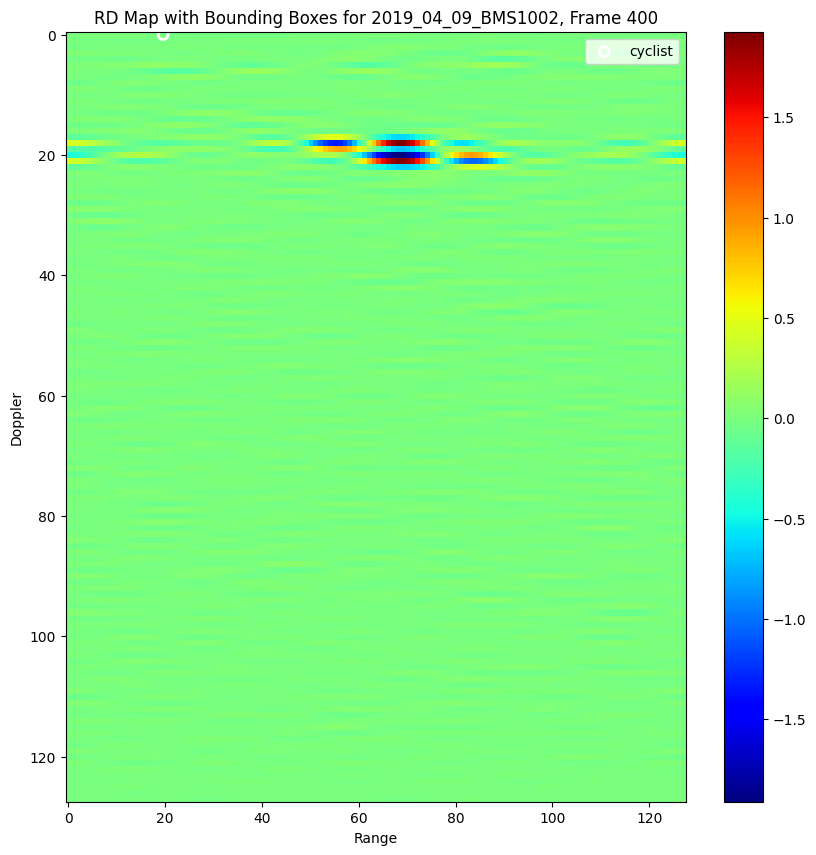

In [50]:
df = pd.DataFrame(combined_data)
plot_rd_map_with_bbox(df, '2019_04_09_BMS1002', 400)  # Change folder and frame_index as needed


## Raddet dataset

## Carrada Dataset

### Processed Carrada

#### Define paths

In [3]:
seq_name = '2020-02-28-13-09-58'
instances = ['001114', '001115']
frame_name = '000117'
carrada = '/home/hawk/Desktop/data/carrada/Carrada'
seq_path = os.path.join(carrada, seq_name)
rd_path = os.path.join(seq_path, 'range_doppler_numpy', frame_name + '.npy')
ra_path = os.path.join(seq_path, 'range_angle_numpy', frame_name + '.npy')
img_path = os.path.join(seq_path, 'camera_images', frame_name + '.jpg')
annotations_path = os.path.join(carrada, 'annotations_frame_oriented.json')

#### load ra and rd maps

In [5]:
with open(annotations_path, 'r') as fp:
    annotations = json.load(fp)
annotations = annotations[seq_name][frame_name]  # Keep annotations of interest
# Range-angle and range-Doppler matrices
'''
# the RA and RD matrices can be computed directly from the RAD tensor
rad_matrix = np.load(rad_path)
data_transformer = DataTransformer(rad_matrix)
ra_matrix = data_transformer.to_ra()
rd_matrix = data_transformer.to_rd()
'''
ra_matrix = np.load(ra_path)
rd_matrix = np.load(rd_path)

#### display an example image

Camera image of the scene 2020-02-28-13-09-58, frame 000117


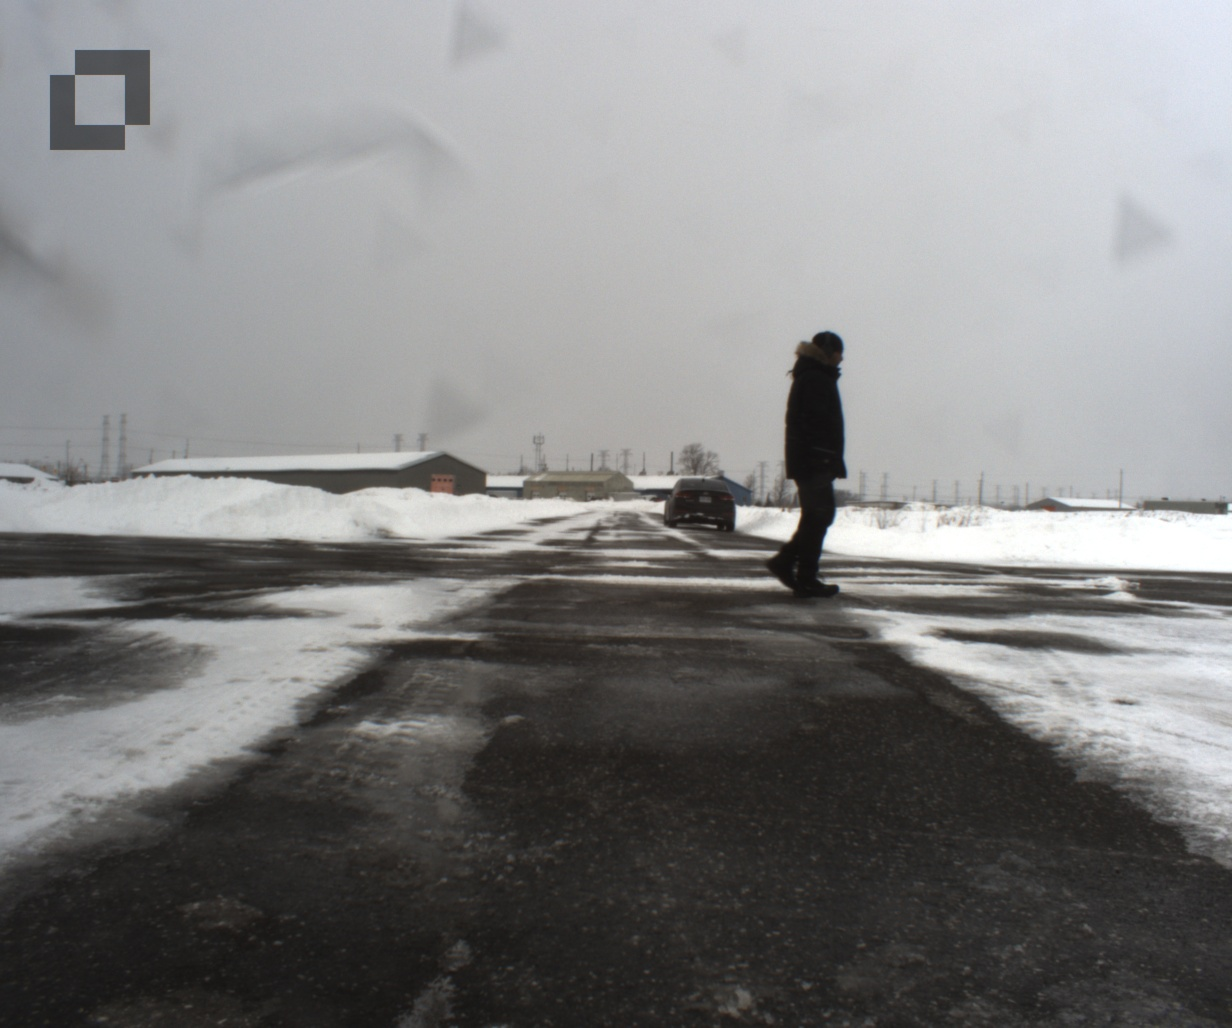

In [7]:
# Camera image of the scene
print('Camera image of the scene {}, frame {}'.format(seq_name, frame_name))
img = Image(img_path)
display(img)

#### display the rd map with the annotations

Raw Range-Doppler representation:


<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?


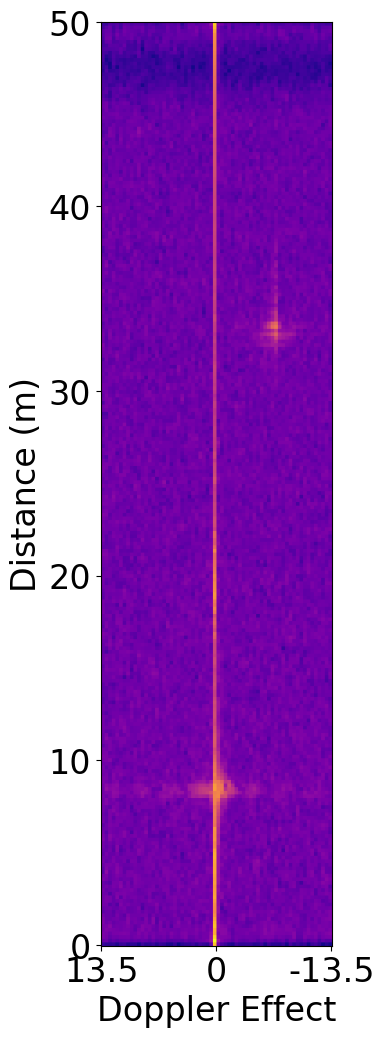

Range-Doppler with sparse annotations:


/tmp/ipykernel_473531/1529025922.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if annotation_type is 'sparse':
/tmp/ipykernel_473531/1529025922.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif annotation_type is 'dense':


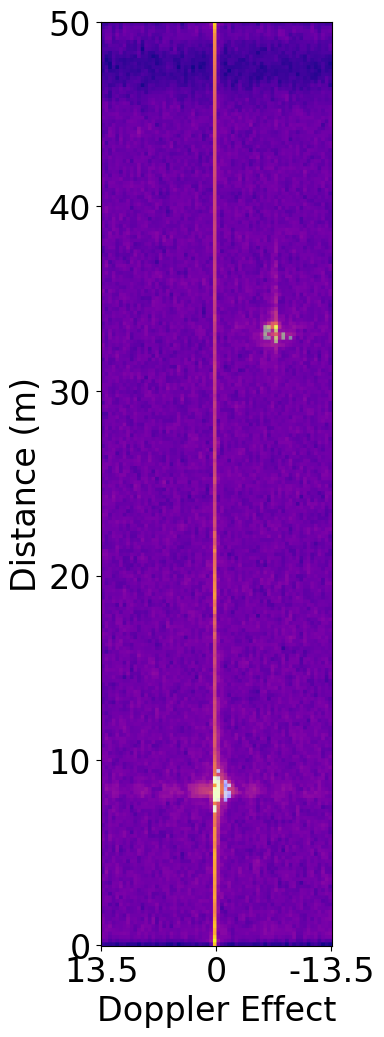

Range-Doppler with dense annotations:


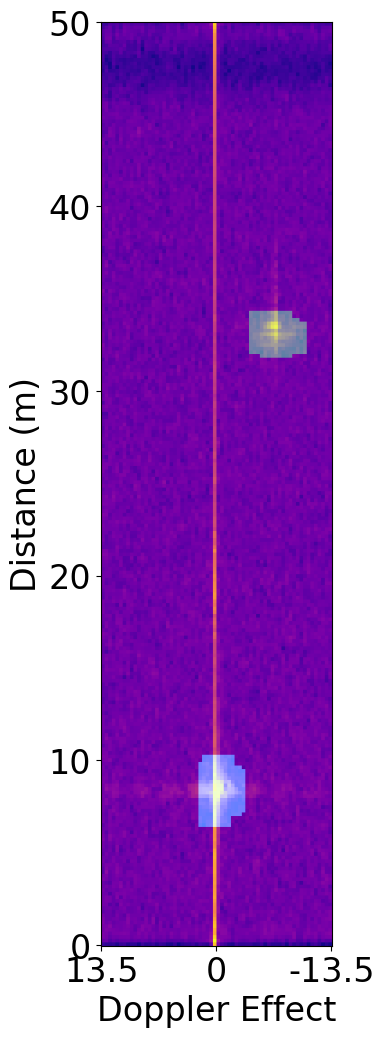

Range-Doppler with box annotations:


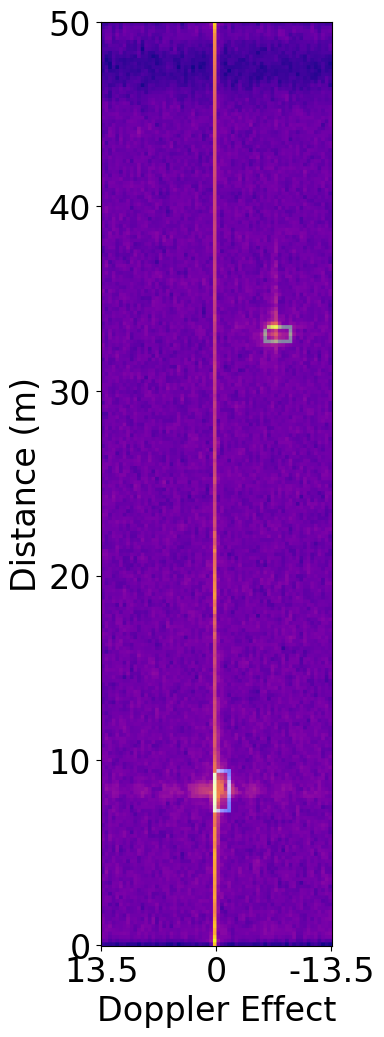

In [8]:
# Range-Doppler visualization
signal_visualizer = SignalVisualizer(rd_matrix)
print('Raw Range-Doppler representation:')
signal_visualizer.save_scale(path='.', signal_type='range_doppler', color_scale=False,
                             rotation=True, save_img=False, plot_img=True)
for annotation_type in ['sparse', 'dense', 'box']:
    for i, instance in enumerate(instances):
        points = annotations[instance]['range_doppler'][annotation_type]
        annot_generator = AnnotationGenerator(rd_matrix.shape, points)
        if annotation_type is 'sparse':
            annots = annot_generator.get_points()
        elif annotation_type is 'dense':
            annots = annot_generator.get_mask()
        else:
            annots = annot_generator.get_box()
        signal_visualizer.add_annotation(i, annots, annotation_type)
    print('Range-Doppler with {} annotations:'.format(annotation_type))
    signal_visualizer.save_multiple_annotations(path='/root/workspace/temp/rd_{}.png'.format(annotation_type),
                                                signal_type='range_doppler', color_scale=False,
                                                rotation=True, save_img=False, plot_img=True)
    signal_visualizer.reset_annotation()

#### display the ra map with the annotations

<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?


Raw Range-Angle representation:


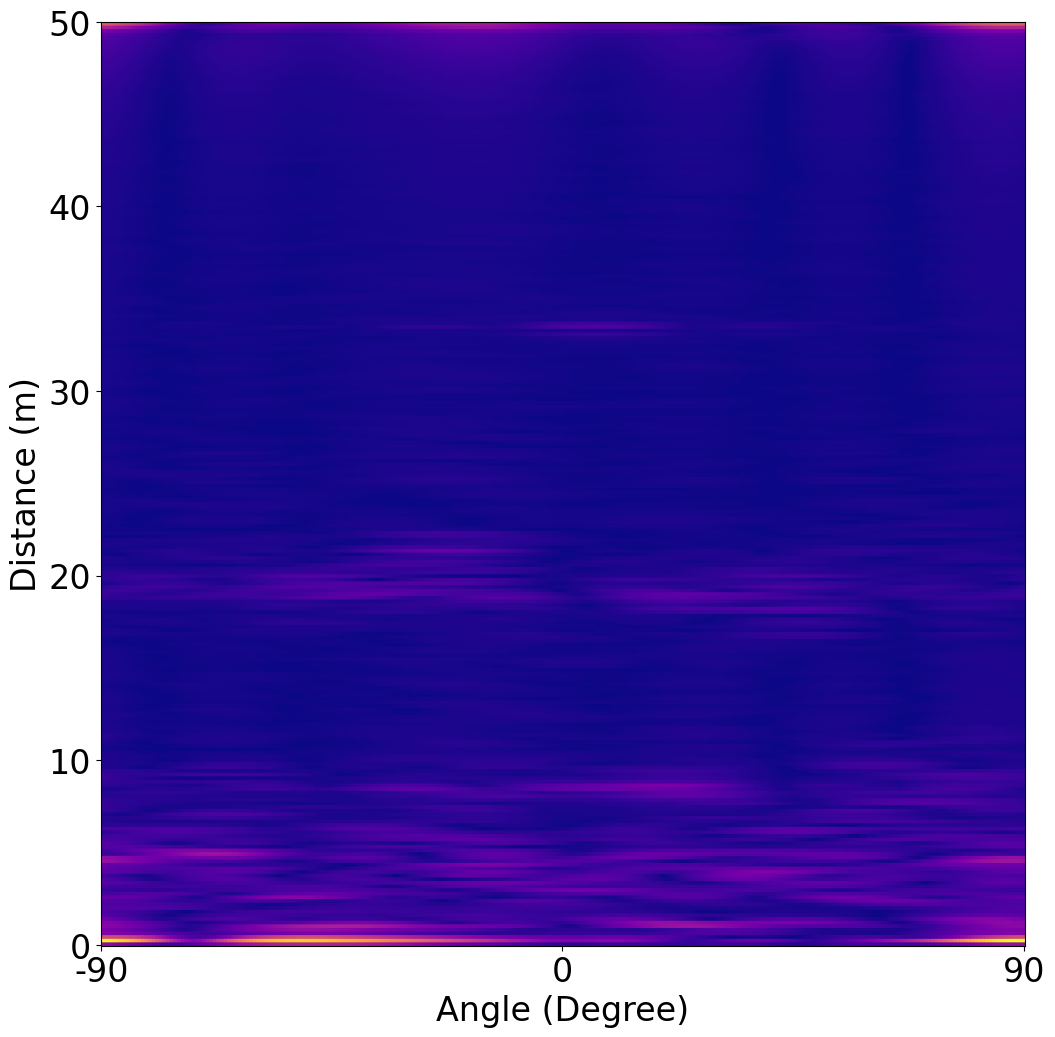

Range-Angle with sparse annotations:


/tmp/ipykernel_473531/3271338884.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if annotation_type is 'sparse':
/tmp/ipykernel_473531/3271338884.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif annotation_type is 'dense':


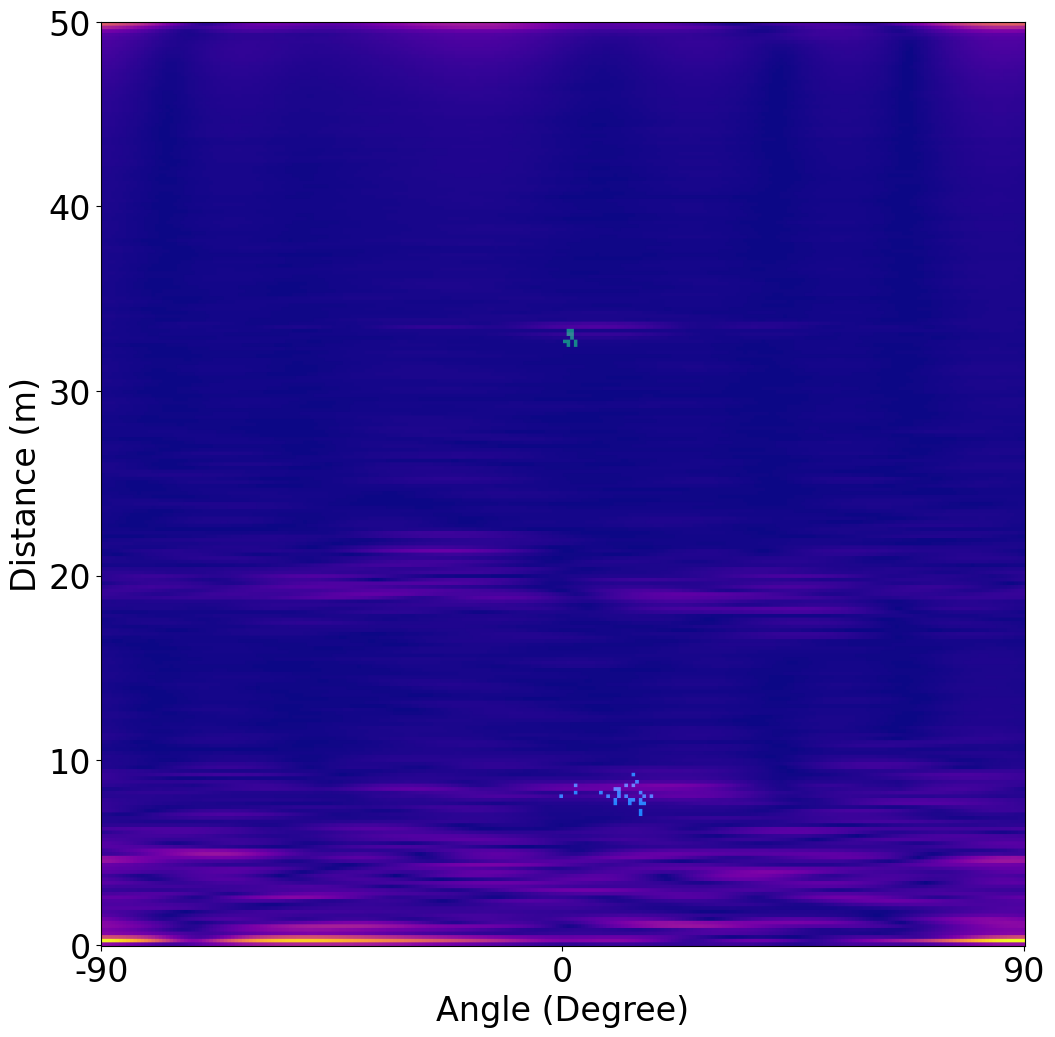

Range-Angle with dense annotations:


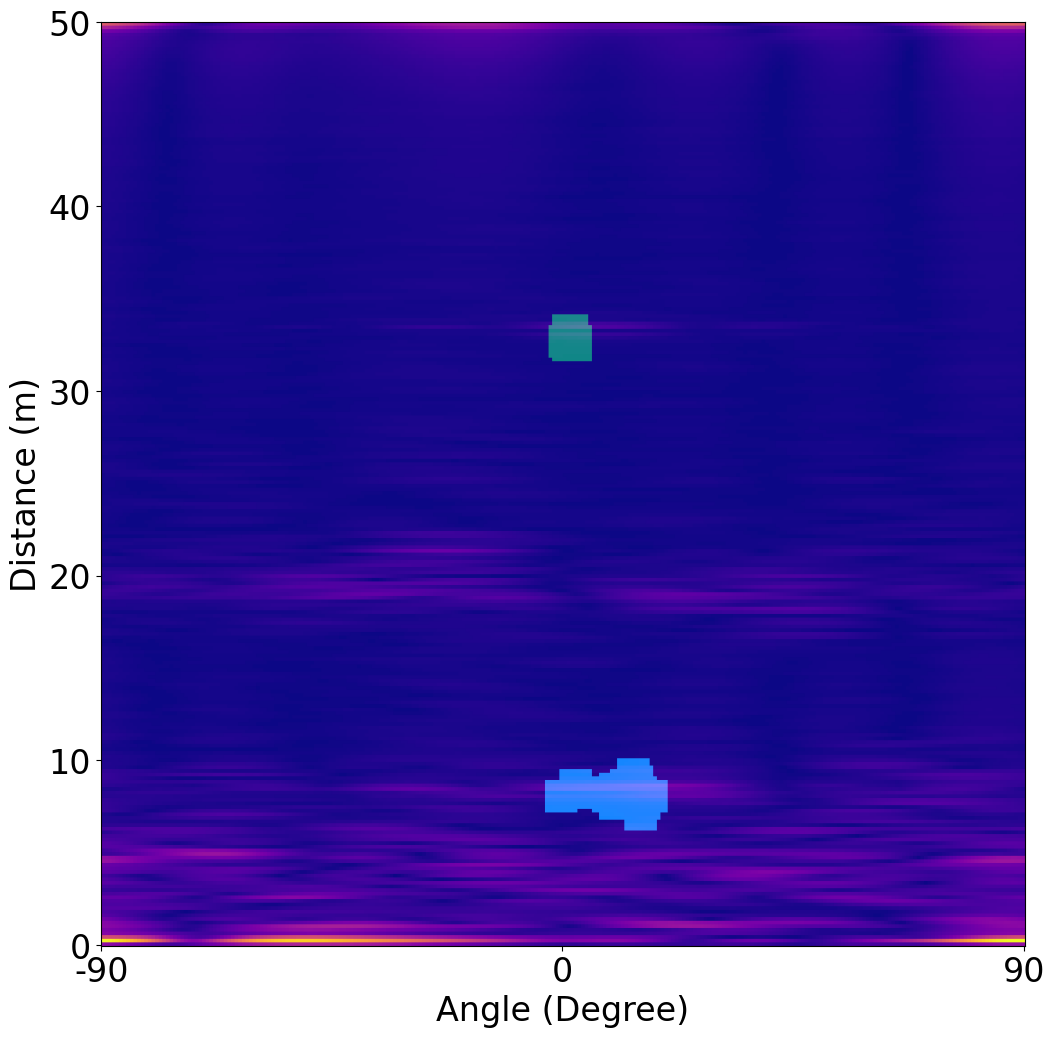

Range-Angle with box annotations:


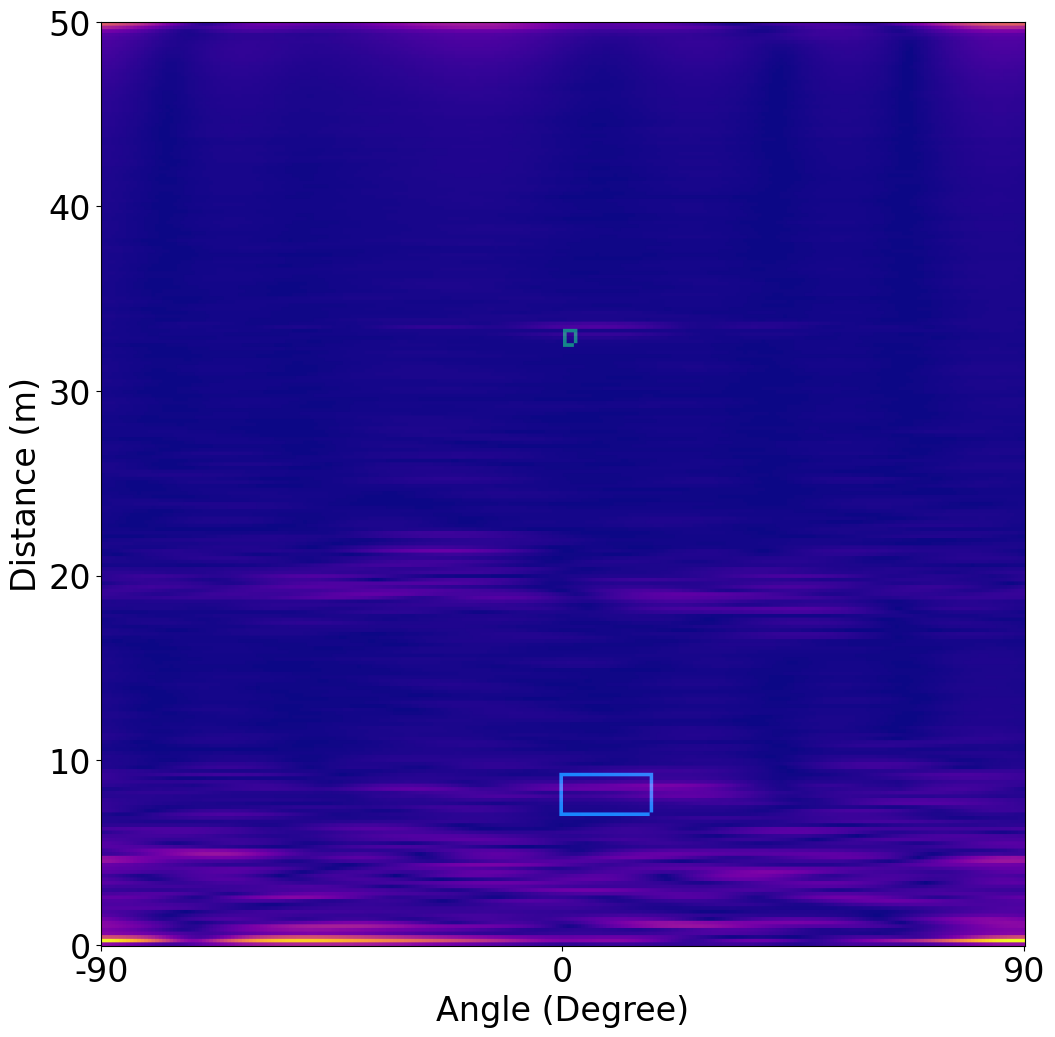

In [9]:
# Range-Angle visualization
signal_visualizer = SignalVisualizer(ra_matrix)
print('Raw Range-Angle representation:')
signal_visualizer.save_scale(path='.', signal_type='range_angle', color_scale=False,
                             rotation=False, save_img=False, plot_img=True)
for annotation_type in ['sparse', 'dense', 'box']:
    for i, instance in enumerate(instances):
        points = annotations[instance]['range_angle'][annotation_type]
        annot_generator = AnnotationGenerator(ra_matrix.shape, points)
        if annotation_type is 'sparse':
            annots = annot_generator.get_points()
        elif annotation_type is 'dense':
            annots = annot_generator.get_mask()
        else:
            annots = annot_generator.get_box()
        signal_visualizer.add_annotation(i, annots, annotation_type)
    print('Range-Angle with {} annotations:'.format(annotation_type))
    signal_visualizer.save_multiple_annotations(path='/root/workspace/temp/ra_{}.png'.format(annotation_type),
                                                signal_type='range_angle', color_scale=False,
                                                rotation=False, save_img=False, plot_img=True)
    signal_visualizer.reset_annotation()

### Pre-proccessed Carrada

## NN

In [10]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F

# Define the transformation
class Transform:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

# Define the dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.images = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "annotations"))))

    def __getitem__(self, idx):
        # Load image and annotation
        img_path = os.path.join(self.root, "images", self.images[idx])
        annotation_path = os.path.join(self.root, "annotations", self.annotations[idx])
        img = Image.open(img_path).convert("RGB")
        with open(annotation_path) as f:
            target = json.load(f)

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.images)

# Load dataset
dataset = CustomDataset(root='path/to/dataset', transforms=Transform())
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/dataset/images'

In [ ]:
num_classes = 2  # 1 class (person) + background
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


In [ ]:
import torch.optim as optim

# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        i += 1
        print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(data_loader)}], Loss: {losses.item():.4f}")


In [ ]:
model.eval()
with torch.no_grad():
    for images, targets in val_data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images)
        # Perform evaluation (e.g., calculate mAP)


In [ ]:
from PIL import Image

def predict(image_path):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img = F.to_tensor(img).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(img)
    return prediction

# Example usage
image_path = 'path/to/test/image.jpg'
prediction = predict(image_path)
print(prediction)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
checkFile = np.load('/home/hawk/Desktop/data/CRUW/TEST_RAD_H/2019_05_28_CM1S013/RADAR_RA_H/000005_0000.npy')


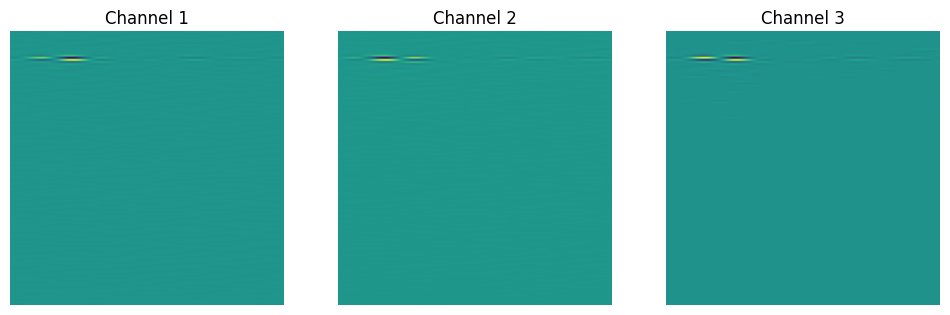

In [ ]:
channel_1 = checkFile[:, :, 0]
channel_2 = checkFile[:, :, 1]
channel_3 = channel_1-channel_2

# Plot the data for each channel
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Plot channel 1
ax[0].imshow(channel_1, cmap='viridis')
ax[0].set_title('Channel 1')
ax[0].axis('off')

# Plot channel 2
ax[1].imshow(channel_2, cmap='viridis')
ax[1].set_title('Channel 2')
ax[1].axis('off')

# Plot channel 1
ax[2].imshow(channel_3, cmap='viridis')
ax[2].set_title('Channel 3')
ax[2].axis('off')

plt.show()

Are channels identical? False
Channel 1 - min: -6.7510557 max: 6.235514
Channel 2 - min: -6.637074 max: 5.8743434


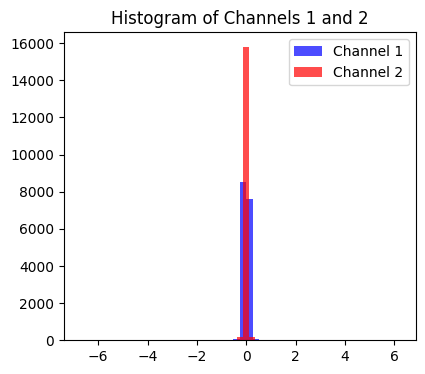

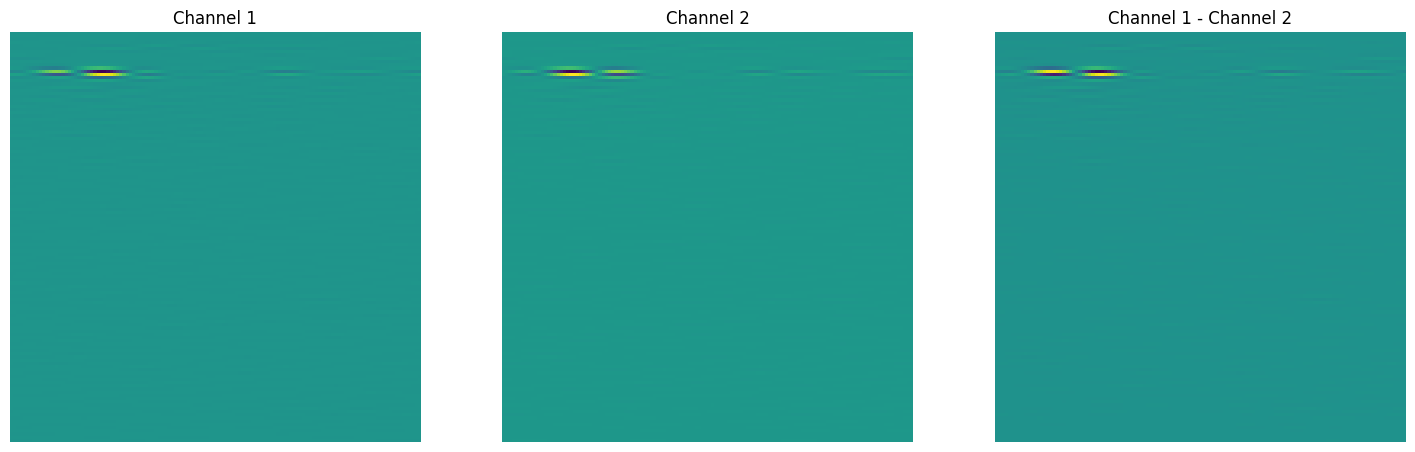

In [ ]:
channel_1 = checkFile[:, :, 0]
channel_2 = checkFile[:, :, 1]

# Check if the channels are identical
are_identical = np.array_equal(channel_1, channel_2)
print("Are channels identical?", are_identical)

# Check the range of values in each channel
print("Channel 1 - min:", np.min(channel_1), "max:", np.max(channel_1))
print("Channel 2 - min:", np.min(channel_2), "max:", np.max(channel_2))

# Check the distribution of values
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(channel_1.ravel(), bins=50, color='blue', alpha=0.7, label='Channel 1')
plt.hist(channel_2.ravel(), bins=50, color='red', alpha=0.7, label='Channel 2')
plt.legend()
plt.title('Histogram of Channels 1 and 2')

# Difference between the channels
channel_diff = channel_1 - channel_2

# Plot the data for each channel and the difference
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot channel 1
ax[0].imshow(channel_1, cmap='viridis')
ax[0].set_title('Channel 1')
ax[0].axis('off')

# Plot channel 2
ax[1].imshow(channel_2, cmap='viridis')
ax[1].set_title('Channel 2')
ax[1].axis('off')

# Plot the difference
ax[2].imshow(channel_diff, cmap='viridis')
ax[2].set_title('Channel 1 - Channel 2')
ax[2].axis('off')

plt.show()


In [ ]:
pip install cruw

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement cruw (from versions: none)
ERROR: No matching distribution found for cruw
Note: you may need to restart the kernel to use updated packages.
